# ClinVar variants in constrained transcripts
This script describes LoF variants in ClinVar in transcripts with regional nonsense constraint

## Preliminaries

In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [2]:
%%bash
# Download data
dx download -f -o ../outputs/ outputs/nmd_annotations.tsv

## VEP data
Find unambiguous nonsense / frameshift variants

In [3]:
vep = (
    pd.read_csv(
        "../outputs/clinvar_variants_vep.vcf",
        sep="\t",
        comment="#",
        header=None,
        names=["chr", "pos", "id", "ref", "alt", "qual", "filter", "info"],
        usecols=["chr", "pos", "ref", "alt", "info"],
    )
    .replace(".", np.nan)
    .dropna()
)

print(f"Variants with a VEP annotation: {len(vep)}")

Variants with a VEP annotation: 1958798


### Extract annotations from the VCF INFO column

In [4]:
i = (
    vep["info"]
    .str.split("|", expand=True)
    .replace("", np.nan)
    .iloc[:, [1, 3, 4, 6]]
    .rename(columns={1: "csq", 3: "hgnc", 4: "ensg", 6: "enst"})
)

### Only unambiguous frameshifts / nonsense variants are kept

In [5]:
i = i[(i.csq == "stop_gained") | (i.csq == "frameshift_variant")]

print(f"Nonsense variants retained: {(i.csq=='stop_gained').sum()}")
print(f"Frameshift variants retained: {(i.csq=='frameshift_variant').sum()}")
print(f"Total retained: {len(i)}")

Nonsense variants retained: 43220
Frameshift variants retained: 73724
Total retained: 116944


### Tidy the VEP annotations

In [6]:
vep = vep.drop("info", axis=1).merge(i, how="inner", left_index=True, right_index=True)
vep = vep[["hgnc", "ensg", "enst", "chr", "pos", "ref", "alt", "csq"]]

## ClinVar data

In [7]:
cv = pd.read_csv("../outputs/clinvar_variants_selected.tsv", sep="\t")

### Combine ACMG annotations

In [8]:
cv = cv.replace(
    {
        "Pathogenic": "P/LP",
        "Likely pathogenic": "P/LP",
        "Uncertain significance": "VUS",
        "Benign": "B/LB",
        "Likely benign": "B/LB",
    }
)

### Split cases with multiple HGNC symbols

In [9]:
cv["hgnc"] = cv.hgnc.str.split(";")
cv = cv.explode("hgnc")

## NMD annotations

In [15]:
nmd = (
    pd.read_csv(
        "../outputs/nmd_annotations.tsv",
        sep="\t",
        usecols=["chr", "pos", "transcript_id", "nmd_definitive"],
    )
    .rename(columns={"transcript_id": "enst", "nmd_definitive": "variant_region"})
    .replace({"nmd_target": "nmd", "distal_nmd": "distal"})
)

## Constrained regions

In [16]:
reg = pd.read_csv("../outputs/constrained_transcripts_all_regions.tsv", sep="\t")

### gnomAD constraint
Find those genes with a pLI or LOEUF annotation

In [17]:
m1 = reg.pli >= 0.9
m2 = reg.loeuf <= 0.35

reg.loc[~reg.pli.isna(), "gnomad"] = "tolerant"
reg.loc[(m1 | m2), "gnomad"] = "constrained"  # Overwrites the line above

### Regional constraint
Find those genes with regional nonsense constraint in UKB

In [18]:
regions = [
    "nmd",
    "distal",
    "long_exon",
]

for region in regions:
    m0 = reg["non_" + region + "_p"] >= 0.001
    m1 = reg["non_" + region + "_p"] < 0.001
    m2 = reg["non_" + region + "_p"] < 0.01
    m3 = reg["non_" + region + "_n_obs"] == 0
    m4 = reg["syn_" + region + "_z"] > -1

    reg.loc[m0 & m4, region] = "tolerant"
    reg.loc[m4 & (m1 | (m2 & m3)), region] = "constrained"

## Merge NMD, VEP, and ClinVar annotations

In [19]:
# VEP + CLinVar
df = vep.merge(cv, how="inner", on=["chr", "pos", "ref", "alt", "hgnc"])
print(f"Variants where the VEP annotation matches the ClinVar gene: {len(df)}")

# ... + NMD
df = df.merge(nmd, how="inner")
del nmd  # A large dataframe
print(f"Variants in canonical transcripts with an NMD annotation: {len(df)}")

# ... + regional constraint
reg = reg[["enst", "gnomad", "nmd", "distal", "long_exon"]]
df = df.merge(reg, how="inner")

Variants where the VEP annotation matches the ClinVar gene: 116786
Variants in canonical transcripts with an NMD annotation: 116758


In [47]:
dfa = df.melt(
    id_vars=["enst", "variant_region", "acmg"],
    value_vars=["gnomad", "nmd", "distal", "long_exon"],
    var_name="constraint_region",
    value_name="constraint",
)

In [48]:
m1 = dfa.constraint_region == "gnomad"
m2 = dfa.variant_region == dfa.constraint_region

dfa = dfa[m1 | m2].dropna()

In [75]:
prop = (
    dfa.groupby(["constraint_region", "constraint"])["acmg"]
    .value_counts(normalize=True)
    .reset_index(name="proportion")
)

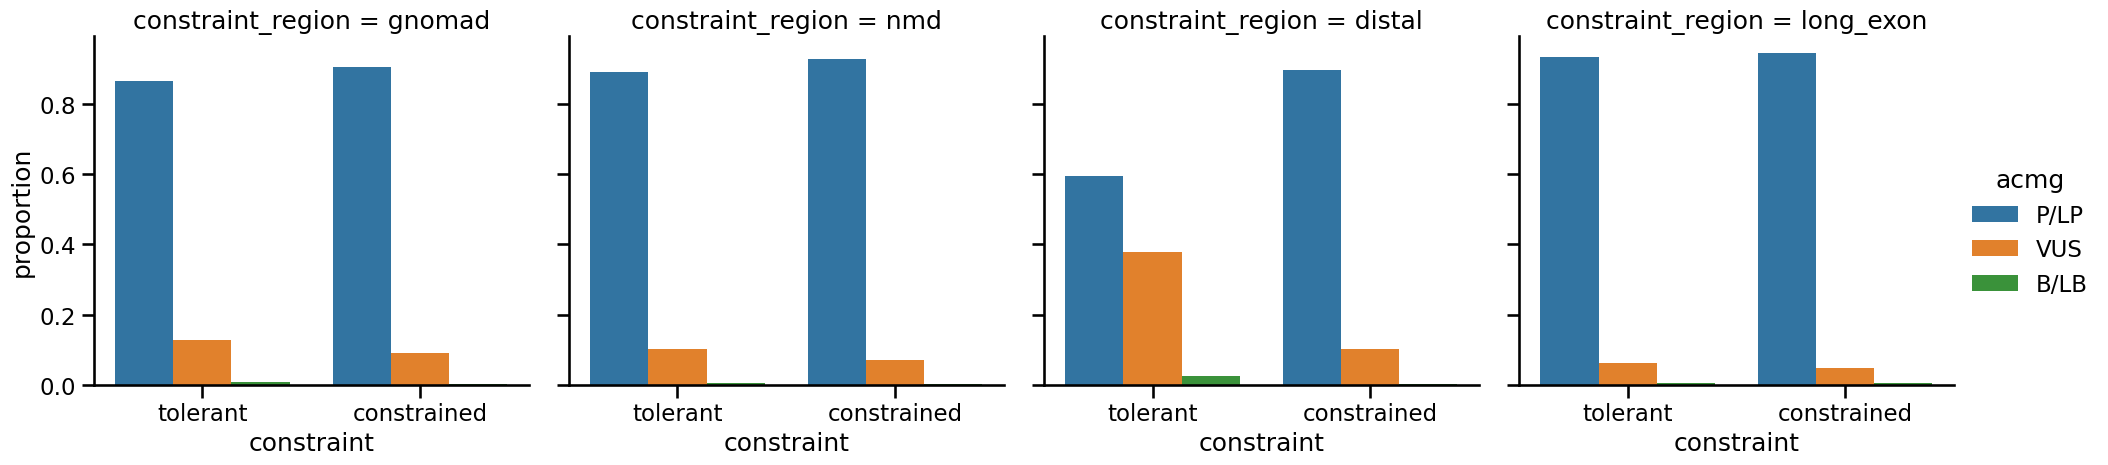

In [81]:
g = sns.catplot(
    kind="bar",
    data=prop,
    x="constraint",
    order=["tolerant","constrained"],
    hue="acmg",
    hue_order=["P/LP","VUS","B/LB"],
    col="constraint_region",
    col_order=["gnomad","nmd","distal","long_exon"],
    y="proportion",
)